# 04 - Model Evaluation: Testing the Best Saved Model

## Goals:
- Load the best trained CropGuard model
- Predict on unseen test images
- Calculate performance metrics (accuracy, precision, recall, F1)
- Visualize model's strengths and weaknesses

# STEP 1 : Load libraries and model

In [3]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

current_dir = os.getcwd()
print(f"[DEBUG] Current working directory: {current_dir}")

project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"[DEBUG] Project root added to sys.path: {project_root}")

from src.data.dataset import PlantVillageDataset
from src.data.augment import AugmentationPipeline
from src.model.architecture import build_model
from src.utils.config import TEST_DIR, BEST_MODEL_PATH

# Load class_to_idx mapping
# (Optional: You can save this mapping during training or infer from test set.)
# Set up augmentation transforms
augment = AugmentationPipeline()

test_ds = PlantVillageDataset(
    root_dir=TEST_DIR,
    transform=augment.get_transforms("val")
)

num_classes = len(test_ds.class_to_idx)  # ✅ Not hardcoding 20 anymore!

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# Build model
model = build_model(num_classes=num_classes, freeze_backbone=False)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model = model.to(device)
model.eval()

[DEBUG] Current working directory: /Users/mitra/vibe_code/CropGuard/notebooks
[DEBUG] Project root added to sys.path: /Users/mitra/vibe_code/CropGuard
[INFO] 3669 images found across 17 classes.
[INFO] Using device: cpu


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# STEP 2: Set up Test DataLoader

In [5]:
# Test Dataset
augment = AugmentationPipeline()

test_ds = PlantVillageDataset(
    root_dir=TEST_DIR,
    transform=augment.get_transforms("val")  # Only normalization
)

test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count()//2,
    pin_memory=True if device.type=="cuda" else False
)

[INFO] 3669 images found across 17 classes.


# STEP 3: Predict and Collate Labels

In [7]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# STEP 4: Calculate Metrics

In [9]:
# Classification report
target_names = list(test_ds.class_to_idx.keys())

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

                                                        precision    recall  f1-score   support

                             grape___Grape___Black_rot     0.9719    0.9774    0.9746       177
                  grape___Grape___Esca_(Black_Measles)     0.9809    0.9856    0.9832       208
    grape___Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     1.0000    0.9815    0.9907       162
                               grape___Grape___healthy     1.0000    1.0000    1.0000        64
                        potato___Potato___Early_blight     1.0000    0.9867    0.9933       150
                         potato___Potato___Late_blight     0.9452    0.9200    0.9324       150
                             potato___Potato___healthy     0.8000    1.0000    0.8889        24
                      tomato___Tomato___Bacterial_spot     0.9279    0.9656    0.9464       320
                        tomato___Tomato___Early_blight     0.8899    0.6467    0.7490       150
                         tomato___Tomat

### Confusion Matrix

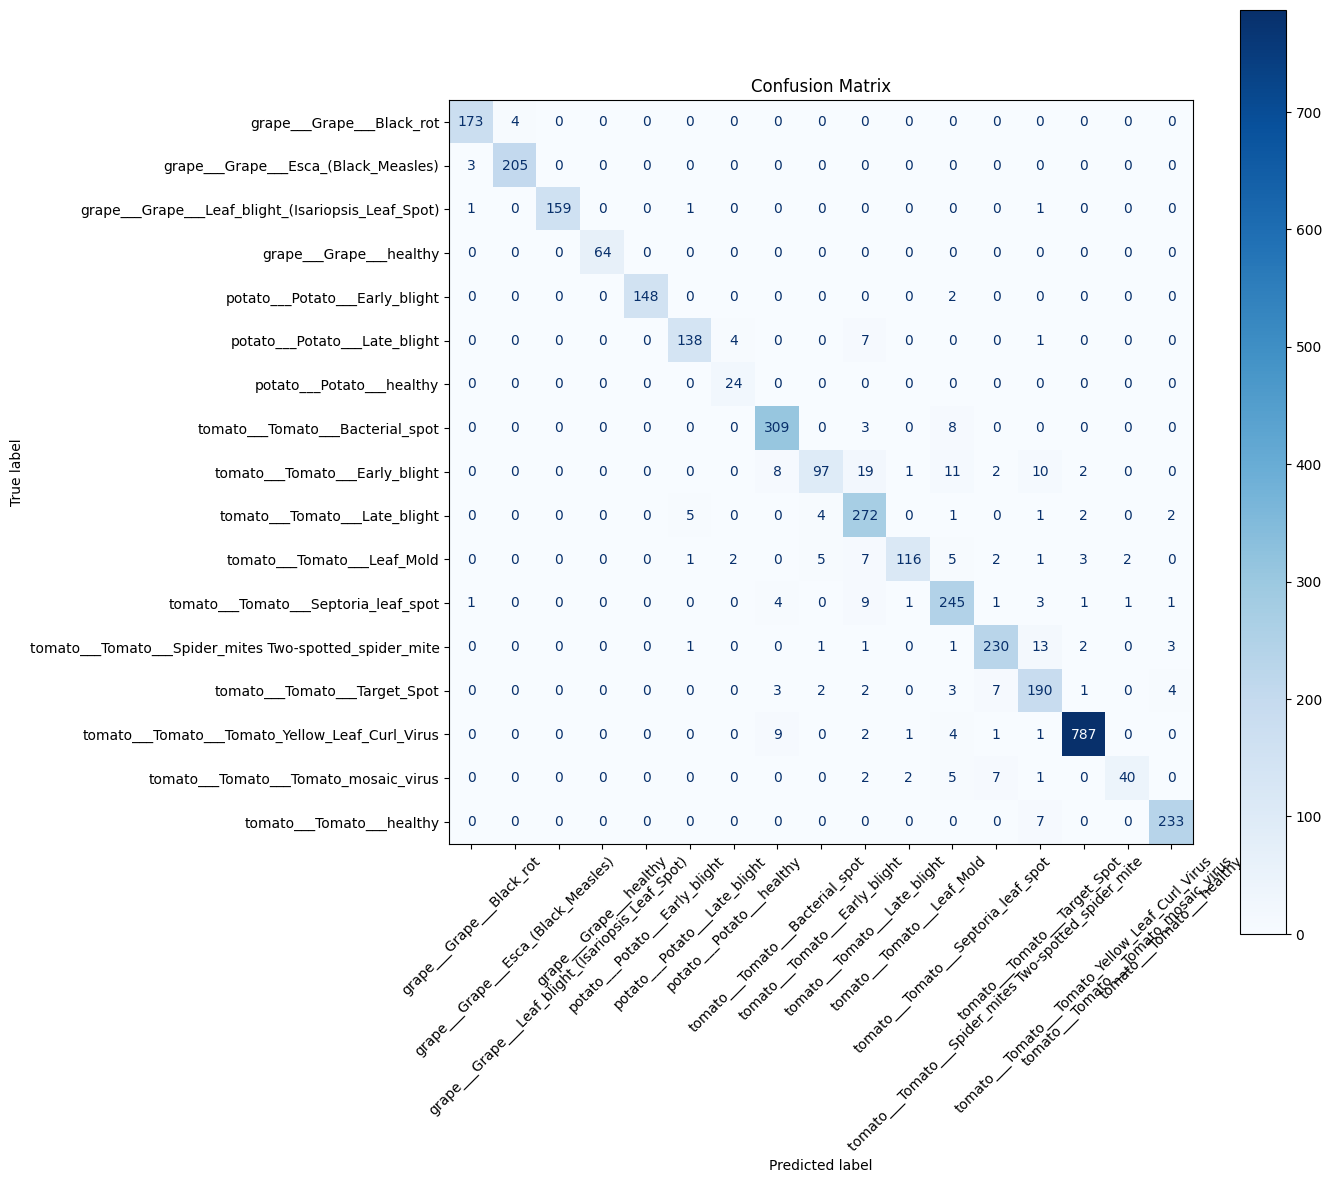

In [11]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

### Visualize Predictions on Test Images

This shows 9 Random 9 from our test set along with their true label and predicted label

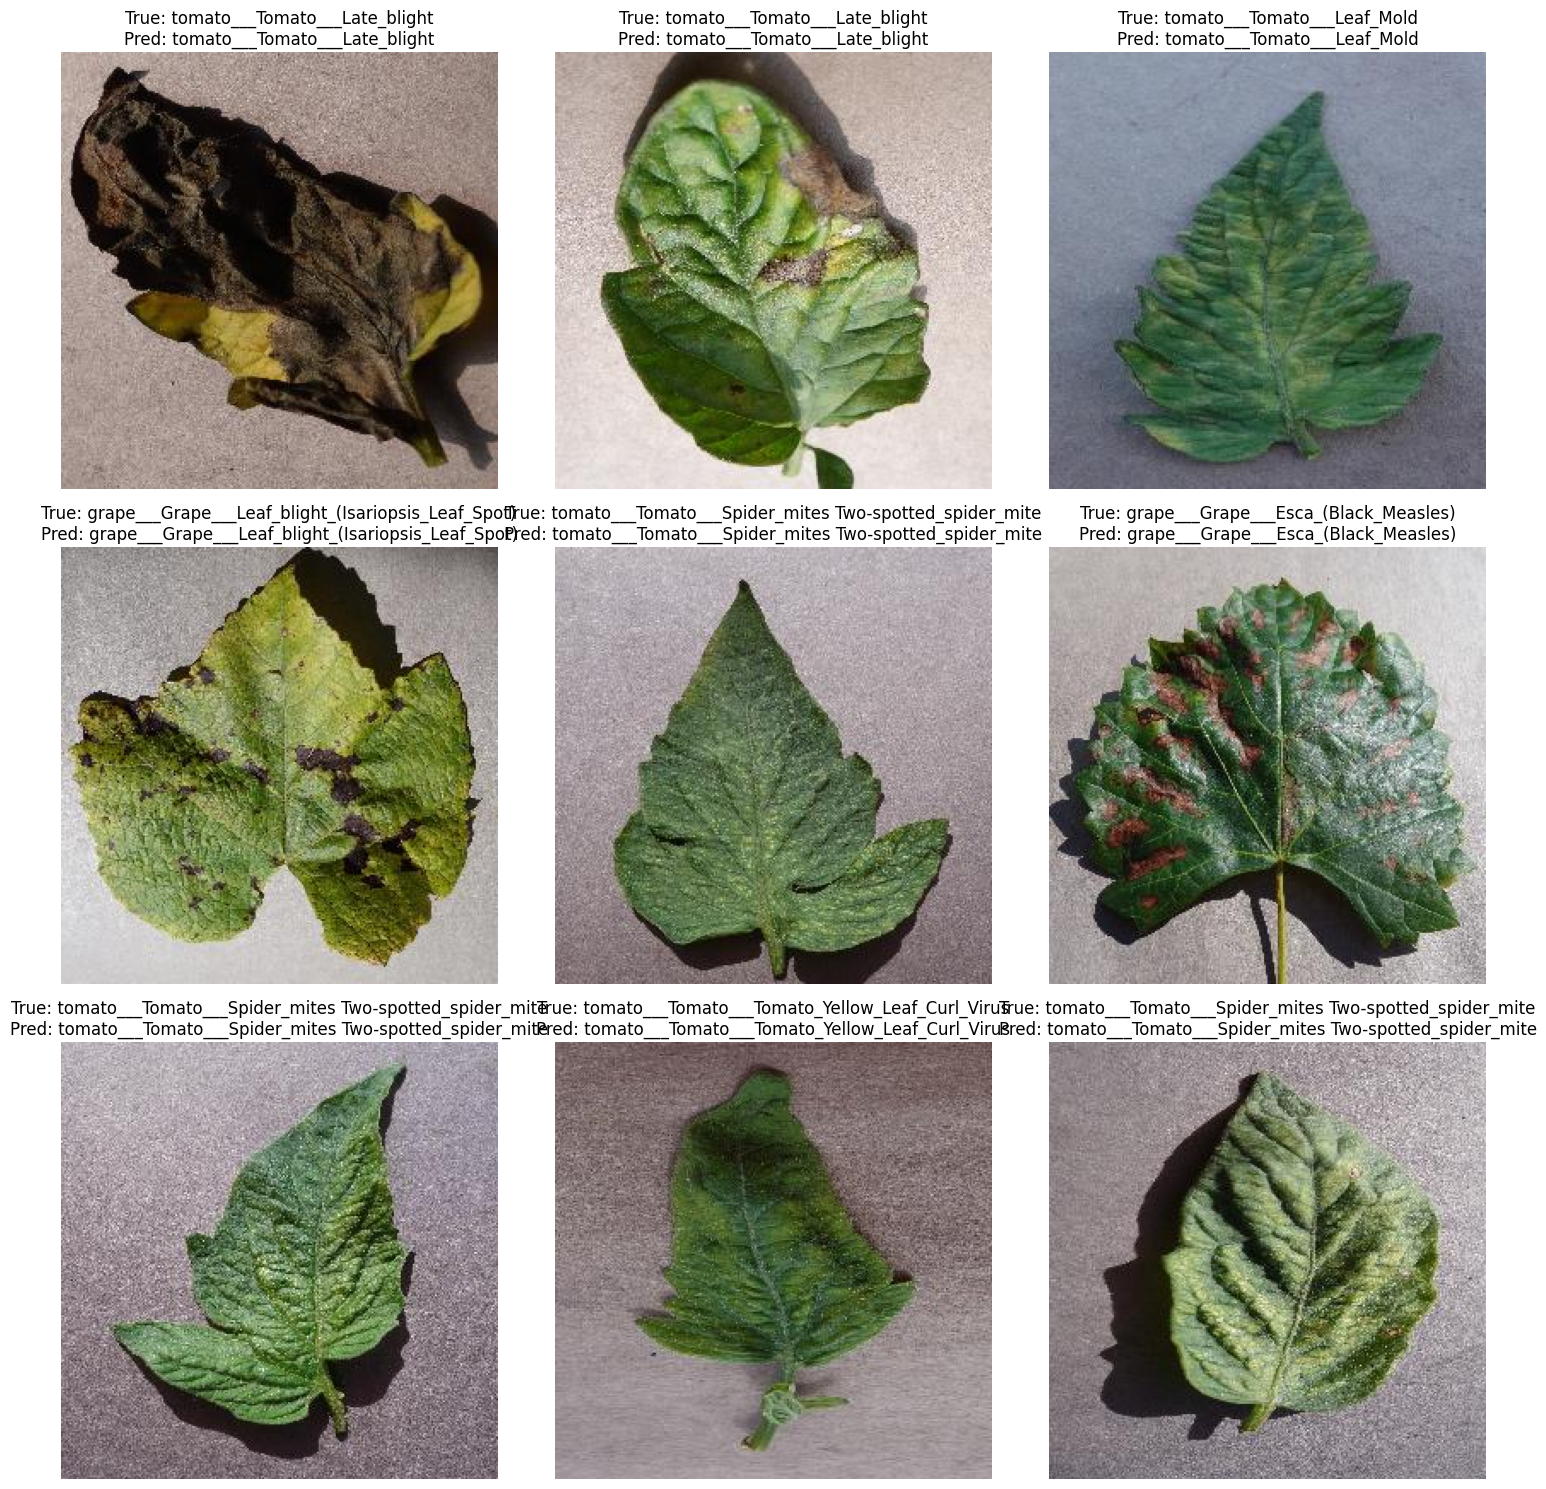

In [13]:
# Visualizing some predictions
import random

def unnormalize(img_tensor):
    """
    Unnormalize a tensor image and convert to NumPy for display.
    Assumes ImageNet normalization.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    return img

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i in range(9):
    idx = random.randint(0, len(test_ds) - 1)
    img, label = test_ds[idx]
    img_show = unnormalize(img)
    
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
    
    true_class = list(test_ds.class_to_idx.keys())[label]
    pred_class = list(test_ds.class_to_idx.keys())[pred.item()]
    
    axes[i].imshow(img_show)
    axes[i].set_title(f"True: {true_class}\nPred: {pred_class}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()